In [1]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pandas==1.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive')
# to use the packages in google drive
sys.path.append('/content/drive/My Drive/6000M_proj2/proj2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LeakyReLU
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import skew, kurtosis
from os.path import join

from config import *

from src.universe import Universe
from src.utils import time_series_generator
from src.metrics import plot_mse

In [5]:
inception_date = '2022-03-31'
ONE_YEAR_TRADE_DAYS = 252
TWO_YEAR_TRADE_DAYS = ONE_YEAR_TRADE_DAYS * 2
WIN_LEN = 30
UNIVERSE_SIZE = 2500
EPOCH = 20
BATCH_SIZE = 16

In [6]:
training_path = Path(join(data_path, 'train_set'))
ret_train = pd.read_csv(join(training_path, '2022-03-31.csv'), index_col=0)

In [7]:
ret_train

,IMPP,SXTC,ECAT,MULN,HYMC,CELZ,METX,ENSV,KAVL,CBIO,...,MGM,ARIS,BIMI,ARQT,FRLA,PCYO,BRP,LIBY,VOR,NPCE
2020-02-20,0.000000,-0.033708,0.000000,0.006250,0.000000,-0.138889,-0.001936,0.421053,0.000000,0.047546,...,0.007791,0.000000,-0.002924,0.011658,0.000000,0.006652,0.022445,0.000000,0.000000,0.000000
2020-02-21,0.000000,0.090698,0.000000,0.012422,0.006111,-0.019355,0.000000,-0.137566,0.000000,0.036603,...,-0.029376,0.000000,0.055718,0.005576,0.000000,0.010279,0.006355,0.000000,0.000000,0.000000
2020-02-24,0.000000,0.000000,0.000000,-0.003067,-0.005109,-0.013158,0.002910,0.000000,0.000000,-0.100282,...,-0.053839,0.000000,0.069444,0.020702,0.000000,-0.021439,-0.017796,0.000000,0.000000,0.000000
2020-02-25,0.000000,-0.041578,0.000000,-0.043077,-0.000969,-0.200000,-0.002901,-0.030675,0.000000,-0.029827,...,-0.060943,0.000000,0.031169,-0.046360,0.000000,-0.027107,0.004676,0.000000,0.000000,0.000000
2020-02-26,0.000000,0.001112,0.000000,0.012862,0.000000,0.158333,0.000000,-0.088608,0.000000,-0.006473,...,-0.042309,0.000000,0.015113,0.083935,0.000000,-0.002290,-0.001163,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,-0.039106,-0.075000,-0.008573,-0.216667,-0.030303,0.074074,-0.055556,0.002740,-0.019737,0.000000,...,0.000949,0.005391,-0.052632,-0.028265,-0.000996,-0.014778,-0.021517,0.000000,-0.091153,0.001198
2022-03-28,-0.023256,-0.090090,0.001235,0.042553,0.690557,0.304598,0.058824,-0.122951,0.000000,0.000000,...,-0.000237,-0.005898,0.015873,0.014543,0.000499,0.018333,0.028699,0.000000,-0.060472,0.000000
2022-03-29,-0.083333,0.455445,0.009871,-0.040816,0.116379,-0.196035,0.000000,-0.037383,-0.006711,-0.057971,...,0.033657,0.017260,0.171875,0.057913,-0.001495,-0.009820,0.045290,0.000000,0.009419,0.001196
2022-03-30,0.038961,0.027211,0.015272,0.289362,-0.077220,-0.071233,-0.055556,-0.019417,-0.013514,0.015385,...,-0.010319,-0.025981,-0.066667,0.016260,0.000000,-0.005785,-0.047487,0.003018,-0.035770,-0.062127


In [8]:
X, y = time_series_generator(ret_train, WIN_LEN)

In [9]:
train_index = ret_train.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].index
y.shape, len(train_index), train_index[-1]

((504, 2500), 504, '2022-03-31')

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X,y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((378, 30, 2500), (126, 30, 2500), (378, 2500), (126, 2500))

In [11]:
import numpy as np
import math
from numpy.random import normal

import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LeakyReLU, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras import callbacks

# the structure of this CNN1D is different from the one compared to other models.
# Here, it is used to tune the structure.
# The structure refers to https://www.kaggle.com/code/yzgast/cnn-1d-for-stock-prediction/notebook

class CNN1D:
    def __init__(self, win_len, input_dim, filter=[32,64,128], kernel_size=[1,1,1], dense=256, dropout=0.1, act=False):
        self._win_len = win_len
        self._input_dim = input_dim
        self._filter = filter
        self._kernel_size = kernel_size
        self._dense = dense
        self._dropout = dropout
        self._act = act

    def _build_loss(self, sigma: tf.Tensor):
      # TODO: build loss func
        def gaussian_likelihood(y_true, y_pred):
            return tf.reduce_mean(
                tf.math.log(tf.math.sqrt(2 * math.pi))
                + tf.math.log(sigma)
                + tf.math.truediv(
                    tf.math.square(y_true - y_pred), 2 * tf.math.square(sigma)
                )
            )
            
        return gaussian_likelihood

    def build_and_compile(self) -> None:
        inputs = Input(shape=(self._win_len, self._input_dim))
        conv1 = Conv1D(filters=self._filter[0], 
                       kernel_size=self._kernel_size[0], padding='same', 
                       activation='relu', 
                       input_shape=(self._win_len, self._input_dim), 
                       data_format="channels_last")(inputs)
        conv2 = Conv1D(filters=self._filter[1],
                       kernel_size=self._kernel_size[1], padding='same', 
                       activation='relu',data_format="channels_last")(conv1)
        maxpool = MaxPooling1D(pool_size=(1))(conv2)
        conv3 = Conv1D(filters=self._filter[2],
                kernel_size=self._kernel_size[2], padding='same', 
                activation='relu',data_format="channels_last")(maxpool) 
        x = Flatten()(conv3)
        dense = Dense(self._dense)(x)     
        dense = LeakyReLU(alpha=0.01)(dense)
        dropout = Dropout(self._dropout)(dense)
        if self._act == False:
           dense_out = Dense(self._input_dim)(dropout)
        else:
            dense_out = Dense(self._input_dim, activation='relu')(dropout)

        model = Model(inputs, dense_out)

        # TODO 改loss func
        model.compile(
            loss='mse',
            metrics=['mse'],
        )

        self._model = model

    def get_model(self) -> Model:
        return self._model

    def summary(self) -> None:
        self._model.summary()

    def fit(self, **kwargs) -> None:
        self._model.fit(**kwargs)
    
    def predict(self, **kwargs):
      pred = self._model.predict(**kwargs)
      return pred

In [12]:
# dropout rate 0.1, no activation function in the last layer
cnn1d = CNN1D(30, 2500)

# dropout rate 0.8, no activation function in the last layer
cnn1d_d = CNN1D(30, 2500, dropout=0.8)

# dropout rate 0.8, no activation function in the last layer
cnn1d_d_a = CNN1D(30, 2500, dropout=0.8, act=True)

In [13]:
cnn1d.build_and_compile()
cnn1d_d.build_and_compile()
cnn1d_d_a.build_and_compile()

In [14]:
cnn1d.fit(x=X_train, y=y_train,
                    epochs=EPOCH,
                    validation_data=(X_val, y_val),
             )

Epoch 1/20
12/12 [==============================] - 6s 248ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/20
12/12 [==============================] - 1s 109ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/20
12/12 [==============================] - 1s 92ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/20
12/12 [==============================] - 1s 112ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/20
12/12 [==============================] - 1s 101ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/20
12/12 [==============================] - 1s 91ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/20
12/12 [==============================] - 1s 97ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 8/20
12/12 [==============================] - 1s 105ms/step - loss: 0.002

In [15]:
cnn1d_d.fit(x=X_train, y=y_train,
                    epochs=EPOCH,
                    validation_data=(X_val, y_val),
             )

Epoch 1/20
12/12 [==============================] - 3s 138ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/20
12/12 [==============================] - 1s 53ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/20
12/12 [==============================] - 1s 49ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/20
12/12 [==============================] - 1s 52ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/20
12/12 [==============================] - 1s 51ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/20
12/12 [==============================] - 1s 50ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/20
12/12 [==============================] - 1s 48ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/20
12/12 [==============================] - 1s 49ms/step - loss: 0.0026 - 

In [16]:
cnn1d_d_a.fit(x=X_train, y=y_train,
                    epochs=EPOCH,
                    validation_data=(X_val, y_val),
             )

Epoch 1/20
12/12 [==============================] - 2s 70ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 2/20
12/12 [==============================] - 1s 55ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/20
12/12 [==============================] - 1s 52ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/20
12/12 [==============================] - 1s 50ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/20
12/12 [==============================] - 1s 54ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/20
12/12 [==============================] - 1s 83ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/20
12/12 [==============================] - 1s 119ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/20
12/12 [==============================] - 2s 143ms/step - loss: 0.0026 -

In [17]:
training_path = Path(join(data_path, 'train_set'))
liquid_ticker_ret = pd.read_csv(join(training_path, 'liquid_ticker_ret.csv'), index_col=0)
liquid_ticker_ret

,IMPP,SXTC,ECAT,MULN,HYMC,CELZ,METX,ENSV,KAVL,CBIO,...,MGM,ARIS,BIMI,ARQT,FRLA,PCYO,BRP,LIBY,VOR,NPCE
2018-06-04,0.000000,0.000000,0.000000,-0.028369,0.000000,0.084848,0.000000,-0.081481,0.000000,0.022102,...,-0.007864,0.000000,0.046875,0.000000,0.000000,-0.025641,0.000000,0.000000,0.000000,0.000000
2018-06-05,0.000000,0.000000,0.000000,-0.013139,0.000000,-0.134078,0.000000,-0.032258,0.000000,-0.019584,...,-0.021560,0.000000,0.171642,0.000000,0.000000,0.015789,0.000000,0.000000,0.000000,0.000000
2018-06-06,0.000000,0.000000,0.000000,-0.039941,-0.001041,-0.038710,0.000000,0.016667,0.000000,0.022056,...,0.022359,0.000000,0.082803,0.000000,0.000000,-0.010363,0.000000,0.000000,0.000000,0.000000
2018-06-07,0.000000,0.000000,0.000000,-0.001541,0.003125,0.033557,0.000000,-0.008197,0.000000,-0.024837,...,-0.002545,0.000000,0.082353,0.000000,0.000000,0.005236,0.000000,0.000000,0.000000,0.000000
2018-06-08,0.000000,0.000000,0.000000,0.141975,0.000000,0.103896,0.000000,-0.033058,0.000000,0.000417,...,-0.018182,0.000000,0.084239,0.000000,0.000000,-0.020833,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,0.229412,0.007067,0.001362,-0.090909,-0.010283,-0.014151,-0.083333,0.056818,-0.005161,-0.047619,...,0.015081,0.016250,0.055556,0.007820,-0.019354,0.009772,0.011532,0.000000,-0.044218,0.110294
2023-03-28,-0.066986,-0.017544,0.004762,-0.100000,0.096104,-0.006507,0.000000,-0.008602,-0.033722,-0.050000,...,0.001917,-0.023370,-0.035088,-0.006790,0.004721,-0.008602,0.000000,0.000000,-0.023132,0.006622
2023-03-29,-0.005128,0.000000,0.016249,0.111111,-0.052133,-0.038721,0.000000,-0.045553,0.006711,0.052632,...,0.030376,-0.020151,-0.018182,0.045898,0.005639,0.010846,-0.002850,0.000000,-0.032787,0.008772
2023-03-30,-0.051546,-0.017857,0.012658,0.200000,0.092500,-0.028858,0.000000,0.045455,-0.045333,0.000000,...,0.005803,0.010283,-0.037037,0.017740,-0.002804,0.002146,0.021233,0.000476,-0.013183,0.069565


<Axes: ylabel='Density'>

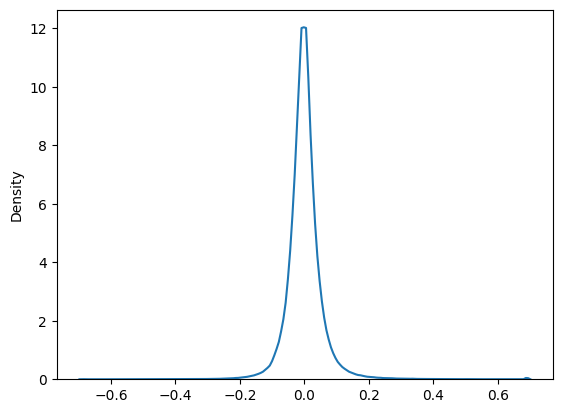

In [18]:
ret_train = liquid_ticker_ret.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS-WIN_LEN:]
train_index = ret_train.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].index
train_flat = ret_train.values.flatten()
train_flat = train_flat[train_flat != 0]
m = train_flat.mean()
s = train_flat.std()
train_flat = train_flat.clip(m-2*s, m+2*s)
sns.kdeplot(train_flat)

In [19]:
## get ticker returns
test_start_date = liquid_ticker_ret.loc[:inception_date].iloc[-WIN_LEN:].index[0]
ret_test = liquid_ticker_ret.loc[test_start_date:].iloc[:ONE_YEAR_TRADE_DAYS + WIN_LEN+1]
ret_test = ret_test.clip(m-2*s, m+2*s)
X_test, y_test = time_series_generator(ret_test, WIN_LEN)

In [20]:
cnn1d_pred = cnn1d.predict(x=X_test)
cnn1d_d_pred = cnn1d_d.predict(x=X_test)
cnn1d_d_a_pred = cnn1d_d_a.predict(x=X_test)

8/8 [==============================] - 0s 19ms/step


In [21]:
from src.metrics import plot_mse, generate_report
generate_report(
    [cnn1d_pred, cnn1d_d_pred, cnn1d_d_a_pred], y_test, 
    ['cnn1d_dropout_rate_0.1', 'cnn1d_dropout_rate_0.8', 'cnn1d_last_layer_activation']
)

,mse,corr,deviation
cnn1d_dropout_rate_0.1,0.002655,-0.000680,1.060291
cnn1d_dropout_rate_0.8,0.002652,-0.000169,1.055319
cnn1d_last_layer_activation,0.002650,-0.003674,0.980518
